This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [15]:
NUMBER_OF_BATCHES = 1000
BATCH_SIZE = 10
NUMBER_OF_GAMES = NUMBER_OF_BATCHES * BATCH_SIZE

In [16]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):

        #return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)
        #return 0.5 / (1 + rate_val * turn) 

        return 0.5 * np.exp(-rate_val * turn) #my new proposed fucntion

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        #return 1 + max_rate * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
        #return 1 + (max_rate - 1) * ((turn/(NUMBER_OF_BATCHES * BATCH_SIZE))**3)
        return np.pow(10000, np.pow(turn/(NUMBER_OF_GAMES), rate_val )) #my new proposed function

    return tau


In [17]:

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [18]:
alpha_exponents = np.linspace(-4, -10, 10)
alpha_values = np.pow(10, alpha_exponents)
tau_exponents = np.linspace(-3, 3, 10 )
tau_values = np.pow(10, tau_exponents)
print(alpha_values)
print(tau_values)
print(tau_exponents)

[1.00000000e-04 2.15443469e-05 4.64158883e-06 1.00000000e-06
 2.15443469e-07 4.64158883e-08 1.00000000e-08 2.15443469e-09
 4.64158883e-10 1.00000000e-10]
[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]
[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]


In [19]:
def try_different_hyperparams(alpha_rates, tau_rates, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_rate in enumerate(tau_rates):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_rate))

            results = results/(BATCH_SIZE * 50)
        
            #records the resultsplayer_x_label='x', player_o_label='o', 
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_rate}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            o_winrate = np.mean(results[:, 0][-5:])
            drawrate = np.mean(results[:, 1][-5:])
            x_winrate = np.mean(results[:, 2][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_rate, 'o_winrate': o_winrate, 'drawrate': drawrate, 'x_winrate': x_winrate}
            df_list.append(new_results)

            print(f"{player}_vs_{strategy}: {((a * 10 + b + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")
            print(f"'alpha_rate' {alpha_rate}, 'tau_rate': {tau_rate}, 'o_winrate': {o_winrate:.3f}, 'drawrate': {drawrate:.3f}, 'x_winrate': {x_winrate:.3f}")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [20]:
#try_different_hyperparams(alpha_values, tau_values, 'x', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'x', 'random')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'random')


In [21]:
df = pd.read_csv('parameter_results/x_vs_perfect/hyperparams.csv')

Text(0.5, 1.0, 'Max drawrate achieved 99.80%')

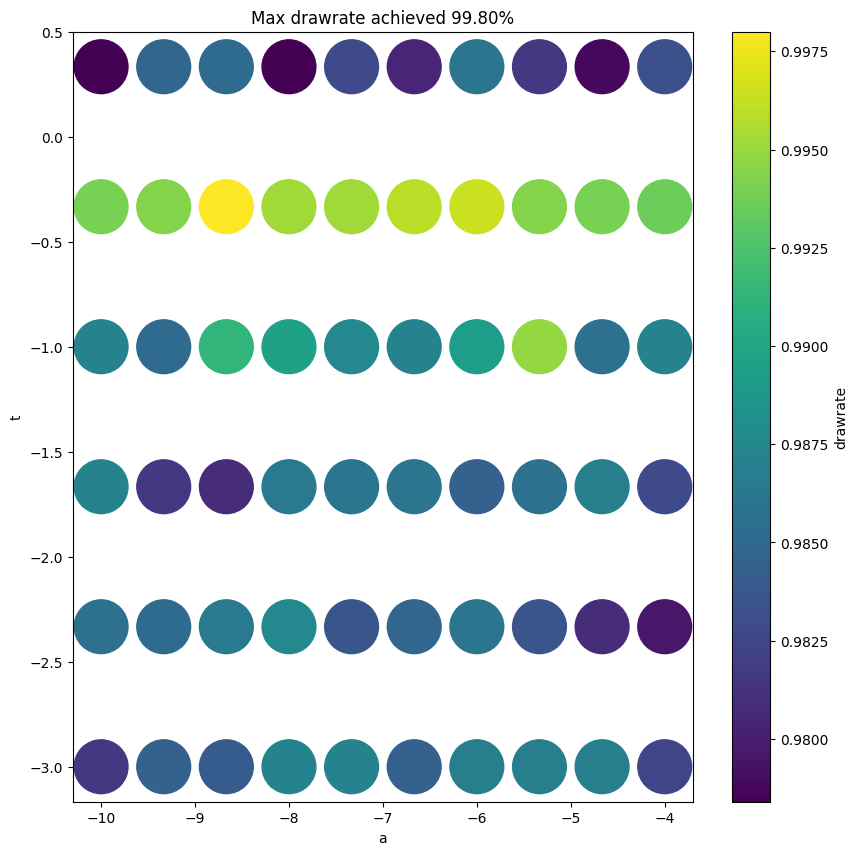

In [22]:
# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

mask = df[np.log10(df['tau_rate']) < 1]#[np.log10(df['alpha_rate']) <= -4][np.log10(df['tau_rate']) <= -2]

x = np.log10(mask['alpha_rate'])
y = np.log10(mask['tau_rate'])
z = mask['drawrate']

# 2. Capture the return value (the "mappable")
scatter = ax.scatter(x, y, c=z, s=1500, cmap='viridis') # cmap is optional but recommended

# 3. Pass the scatter object to the colorbar
fig.colorbar(scatter, ax=ax, label=z.name)
ax.set_xlabel('a')
ax.set_ylabel('t')
ax.set_title(f"Max {z.name} achieved {z.max() * 100 :.2f}%")

I have found good parameters for alpha rate and tau rate which should be implemented:

alpha_rate 10^-7

tau_rate = 10^-0.333


Now the goal is to create a matrix:

I will train 4 models on those parameters and record the results after playing 1000 games against each other using tau as the softmax

In [23]:
alpha = make_alpha(np.pow(10.0, -7))
tau = make_tau(np.pow(10.0, -1/3))

Q_Table_X_Perfect, results = qlb.perform_training('x', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_X_Random, results = qlb.perform_training('x', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Perfect, results = qlb.perform_training('o', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])
Q_Table_O_Random, results = qlb.perform_training('o', 'random', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)
print(results[-1, :])

[  2 498   0]
[  9  17 474]
[  0 499   1]
[428  36  36]


In [24]:
Q_Table_X_Perfect, results = qlb.perform_training('x', 'perfect', NUMBER_OF_BATCHES, BATCH_SIZE, False, alpha, tau)

In [26]:
for i in range(10):
    number_of_games_in_the_match = 10000
    results_x_perfect_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 10)
    results_x_perfect_vs_o_random = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
    results_x_random_vs_o_perfect = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 10)
    results_x_random_vs_o_random = qlb.Q_Table_match(Q_Table_X_Random, Q_Table_O_Random, number_of_games_in_the_match, 'softmax', 10)
    results_fully_random_game = qlb.Q_Table_match(Q_Table_X_Perfect, Q_Table_O_Perfect, number_of_games_in_the_match, 'softmax', 1)
    results_another_fully_random_game = qlb.play_random_match(number_of_games_in_the_match)

    results_from_matches = [results_x_perfect_vs_o_perfect, results_x_perfect_vs_o_random, results_x_random_vs_o_perfect, results_x_random_vs_o_random, results_fully_random_game, results_another_fully_random_game]

    for result_from_match in results_from_matches:
        
        print(result_from_match/np.sum(result_from_match))

    print("_________")

[0.1459 0.5754 0.2787]
[0.1732 0.2946 0.5322]
[0.0721 0.7867 0.1412]
[0.1279 0.504  0.3681]
[0.1249 0.5947 0.2804]
[0.133 0.584 0.283]
_________
[0.1354 0.582  0.2826]
[0.1763 0.2974 0.5263]
[0.0778 0.7814 0.1408]
[0.1292 0.5031 0.3677]
[0.1267 0.5813 0.292 ]
[0.1285 0.5866 0.2849]
_________
[0.1423 0.5865 0.2712]
[0.178 0.297 0.525]
[0.0777 0.7885 0.1338]
[0.1289 0.5112 0.3599]
[0.1307 0.5868 0.2825]
[0.1268 0.5883 0.2849]
_________
[0.1411 0.5794 0.2795]
[0.1745 0.2985 0.527 ]
[0.0785 0.7827 0.1388]
[0.1364 0.4975 0.3661]
[0.1262 0.5904 0.2834]
[0.1256 0.5862 0.2882]
_________
[0.1427 0.5856 0.2717]
[0.1758 0.2996 0.5246]
[0.0794 0.7817 0.1389]
[0.1295 0.5076 0.3629]
[0.1248 0.5887 0.2865]
[0.1247 0.5891 0.2862]
_________
[0.1369 0.5875 0.2756]
[0.1708 0.2943 0.5349]
[0.0807 0.7781 0.1412]
[0.1325 0.501  0.3665]
[0.1258 0.5834 0.2908]
[0.1313 0.5751 0.2936]
_________
[0.1389 0.5775 0.2836]
[0.178  0.2935 0.5285]
[0.08   0.7818 0.1382]
[0.1385 0.5038 0.3577]
[0.1233 0.5803 0.2964]
[0.